# City initialization and methods

In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

## Initialization

Use the results obtained from the ``blocksnet.preprocessing`` or use your own data.

In [2]:
blocks = gpd.read_parquet(os.path.join(example_data_path, "blocks.parquet"))
adjacency_matrix = pd.read_pickle(os.path.join(example_data_path, "adjacency_matrix.pickle"))

In [3]:
from blocksnet.models import City

city_model = City(
  blocks_gdf=blocks, 
  adjacency_matrix=adjacency_matrix, 
)

Print city model to get the information about existing service types, CRS and blocks count

In [4]:
print(city_model)

CRS:          : EPSG:32636
Blocks count  : 271
Service types : 
    3.5.1      school               15 min     120/1000 population 
    3.5.1      kindergarten         7 min      61/1000 population  
    3.4.2      hospital             60 min     9/1000 population   
    3.4.1      polyclinic           10 min     13/1000 population  
    5.1.3      pitch                60 min     10/1000 population  
    5.1.2      swimming_pool        30 min     8/1000 population   
    5.1.1      stadium              30 min     10/1000 population  
    3.6.1      theatre              60 min     6/1000 population   
    3.6.1      museum               60 min     3/1000 population   
    3.6.1      cinema               60 min     9/1000 population   
    4.2        mall                 30 min     8/1000 population   
    4.4        convenience          5 min      180/1000 population 
    4.4        supermarket          15 min     900/1000 population 
    12.1       cemetery             40 min     96/10

## Update layers

Update the information about services and buildings using ``.update_services()`` and ``.update_buildings()``.

Specification is described in the ``blocksnet.models.city.ServiceRow``

In [5]:
school = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergarten = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
hospital = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
polyclinic = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

services = {"school": school, "kindergarten": kindergarten,
            "hospital": hospital,"polyclinic": polyclinic}

In [6]:
for service_type, gdf in services.items():
  city_model.update_services(service_type, gdf)

Specification is described in the ``blocksnet.models.city.BuildingRow``

In [7]:
buildings = gpd.read_parquet(os.path.join(example_data_path, "buildings.parquet")).to_crs(local_crs)
buildings = buildings.rename(columns={
  'storeys_count': 'floors',
  'population_balanced': 'population',
  'total_area': 'area'
})

In [8]:
city_model.update_buildings(buildings)

Upload landuse file for existing blocks to update ``LandUse`` according to ``blocksnet.models.city.LandUseRow``

In [9]:
lu = gpd.read_file(os.path.join(example_data_path, "landuse.geojson"))
city_model.update_land_use(lu)

## Methods and other ways to operate the ``City`` model

Plot city model layers with `.plot()`

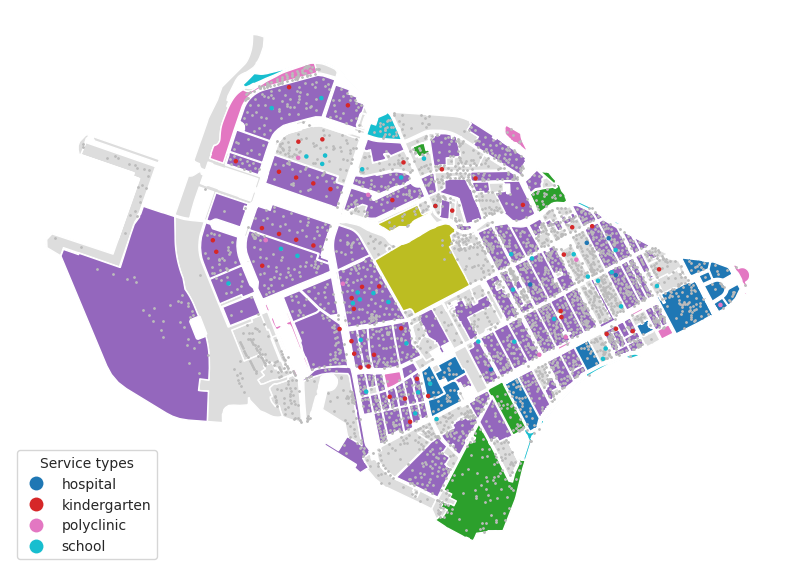

In [10]:
city_model.plot()

Save city model to file with ``.to_pickle()`` so we can use it later

In [10]:
city_model.to_pickle(os.path.join(example_data_path, 'city_model.pickle'))

``Block`` within the city model can be obtained via ``id`` (int)

In [12]:
block = city_model[123]
block

Block(id=123, geometry=<POLYGON ((346460.223 6649125.497, 346465.461 6649128.123, 346465.462 664912...>, land_use=<LandUse.MIXED_USE: 'mixed_use'>, buildings=None, services={}, city=<blocksnet.models.city.City object at 0x7f12698ac670>)

Get available ``ServiceType``s for current ``Block`` ``LandUse``

In [14]:
available_service_types = block.land_use_service_types
[st.name for st in available_service_types]

['school',
 'kindergarten',
 'hospital',
 'polyclinic',
 'pitch',
 'swimming_pool',
 'stadium',
 'theatre',
 'museum',
 'cinema',
 'mall',
 'convenience',
 'supermarket',
 'religion',
 'marketplace',
 'bowling_alley',
 'bank',
 'lawyer',
 'cafe',
 'subway_entrance',
 'hairdresser',
 'restaurant',
 'bar_pub',
 'hotel',
 'post',
 'police']

``ServiceType`` can be obtained the same way by ``name`` (str). The information about accessibility, demand, bricks can be obtained this way.

In [11]:
service_type = city_model['school']
service_type

ServiceType(code='3.5.1', name='school', accessibility=15, demand=120, bricks=[ServiceBrick(capacity=250, area=1.2, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=300, area=1.1, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=600, area=1.3, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=1100, area=1.8, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=250, area=0.2, is_integrated=True, parking_area=0.02), ServiceBrick(capacity=300, area=0.36, is_integrated=True, parking_area=0.03), ServiceBrick(capacity=600, area=0.8, is_integrated=True, parking_area=0.06), ServiceBrick(capacity=1100, area=1.1, is_integrated=True, parking_area=0.1)], land_use=[<LandUse.RESIDENTIAL: 'residential'>, <LandUse.MIXED_USE: 'mixed_use'>, <LandUse.BUSINESS: 'business'>])

Add new ``ServiceType`` to the ``City`` model list

In [13]:
from blocksnet import ServiceType

city_model.add_service_type(ServiceType(code='', name='bakeries', accessibility=30, demand=100, bricks=[]))
city_model['bakeries']

ServiceType(code='', name='bakeries', accessibility=30, demand=100, bricks=[])

Get the distance (min) between two city ``Block``s

In [14]:
city_model.get_distance(0, 1)

9.1

Get blocks ``GeoDataFrame`` via ``.get_blocks_gdf()`` method

In [15]:
blocks_gdf = city_model.get_blocks_gdf()
blocks_gdf.head()

,geometry
id,
0,"POLYGON ((345370.504 6646430.885, 345370.505 6..."
1,"POLYGON ((345254.667 6647047.217, 345254.667 6..."
2,"POLYGON ((345055.642 6646758.330, 345055.643 6..."
3,"POLYGON ((344966.092 6647146.023, 344966.091 6..."
4,"POLYGON ((345082.562 6646776.418, 345082.561 6..."


The same way buildings and services ``GeoDataFrame``s can be obtained with:

- ``.get_buildings_gdf()``
- ``.get_services_gdf()``
- ``.get_service_type_gdf()``

In [16]:
buildings_gdf = city_model.get_buildings_gdf()
buildings_gdf.head()

,geometry,population,floors,area,living_area,is_living
0,POINT (345625.313 6646379.081),0.0,0.0,0.0000,0.0,False
1,POINT (345639.028 6646409.751),0.0,1.0,575.4110,0.0,False
2,POINT (345619.009 6646431.188),0.0,1.0,284.8310,0.0,False
3,POINT (345638.596 6646459.785),0.0,1.0,16.2936,0.0,False
4,POINT (345452.265 6646403.874),0.0,7.0,51867.5500,0.0,False


In [17]:
services_gdf = city_model.get_services_gdf()
services_gdf.head()

,geometry,capacity,service_type
0,POINT (344241.473 6648149.216),1200,school
1,POINT (344950.101 6648432.999),1244,school
2,POINT (344780.761 6648505.608),1200,school
3,POINT (345204.730 6649377.764),1200,school
4,POINT (345042.090 6649454.563),1200,school


In [18]:
kindergarten_gdf = city_model.get_service_type_gdf('kindergarten')
kindergarten_gdf.head()

,geometry,capacity,service_type
0,POINT (30.23680 59.93402),146,kindergarten
1,POINT (30.23554 59.93526),280,kindergarten
2,POINT (30.23494 59.93640),287,kindergarten
3,POINT (30.23266 59.93748),192,kindergarten
4,POINT (30.21797 59.94301),245,kindergarten
